In [8]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time, html
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil
import requests, seaborn as sns
import numba

from sklearn import preprocessing
from collections import defaultdict, Counter, OrderedDict
from datetime import datetime
from pprint import pprint
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer.utils import utils, utils_nb
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
# pd.set_option(fmt='')

## Preview
<br/>

### train.csv
Column | Description
--:--  | --:-- 
msno | user id
song_id | song id
source_system_tab | the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name | name of the layout a user sees.
source_type | an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
target | this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .
<br/>

## songs.csv
Column | Description
--:--  | --:-- 
song_id | 
song_length | in ms
genre_ids | genre category. Some songs have multiple genres and they are separated by
artist_name | 
composer | 
lyricist | 
language |
<br/>

## members.csv
Column | Description
--:--  | --:-- 
msno | 
city | 
bd | age. Note: this column has outlier values, please use your judgement.
gender | 
registered_via | registration method
registration_init_time | format %Y%m%d
expiration_date | format %Y%m%d

## song_extra_info.csv
Column | Description
--:--  | --:-- 
song_id | 
song name | the name of the song.
isrc | International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [2]:
utils.preview('./data/train.csv')

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [3]:
utils.preview('./data/test.csv')

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [4]:
utils.preview('./data/members.csv')

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [5]:
utils.preview('./data/songs.csv')

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
utils.preview('./data/song_extra_info.csv')

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


## Data Exploration
#### 簡單針對幾點去探勘資料
1. 以歌曲為觀點:
    - 歌曲本身年分, 類別(genres), 語言(language)是否會被特殊族群偏愛
    - 歌曲所屬歌手(artist_name), 作詞作曲家(lyricist, composer)是否會被特殊族群偏愛
    - 受歡迎的歌曲(song_pplrty)分布於哪一些族群
2. 以人為觀點:
    - 考慮聽歌偏好是否跟[年齡(bd), 性別(gender), 居住地(city), 租期(expiration_date - registration_init_time)]有關
3. Context考量
    - 是否聽歌偏好會跟[source_system_tab, source_screen_name, source_type]有關

In [ ]:
%%time
_ = inp.Input.instance.clean('./data/train.csv')

In [2]:
%%time
tr = pd.read_pickle('./data/processed/cleaned/tr.pkl')
vl = pd.read_pickle('./data/processed/cleaned/vl.pkl')
members = pd.read_pickle('./data/processed/cleaned/members.pkl')
# Tenure, years range from registration time to expiration 
members['tenure'] = \
    ((members.expiration_date * 86400)
             .map(lambda e: datetime.fromtimestamp(e) if e > 0 else None) - 
     (members.registration_init_time * 86400).map(datetime.fromtimestamp)).dt.days / 365
    
bins = np.array([6, 10, 20, 30, 40, 60, 80])
age_map = pd.Series(['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80', ''])
members['msno_age_catg'] = pd.Series(np.digitize(members.bd, bins)).map(age_map)

songs = pd.read_pickle('./data/processed/cleaned/songs.pkl')
song_extra_info = pd.read_csv('./data/song_extra_info.csv').set_index('song_id')
data = pd.concat([tr, vl], 0, ignore_index=True)
del tr, vl

# Although we don't put name feature for training, but it's good for exploration 
songs['name'] = song_extra_info.name.reindex(songs.song_id).values
songs['song_yy'] = (songs.isrc.str.slice(5, 7)
                         .map(lambda e: 2000 + int(e) if int(e) < 18 else 1900 + int(e), 
                              na_action='ignore'))
# Transform song_yy to songs age
age_bins = pd.Series([0, 1960, 1980, 1990, 2000, 2010, 2015])
age_map = pd.Series([0, 1960, 1980, 1990, 2000, 2010, 2015, 2018])
songs['song_yy'] = (pd.Series(np.digitize(songs.song_yy.fillna(-1), age_bins))
                      .map(age_map).map(str))
del song_extra_info

Wall time: 16.6 s


In [3]:
data = data.merge(members, how='left', on='msno').merge(songs, how='left', on='song_id')
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,msno_age_catg,song_length,genre_ids,artist_name,composer,lyricist,language,isrc,name,song_yy
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,UM5K+g04+9t1SULpbhMfEunp6bS/5AdIQs7FbDqmmBY=,radio,Radio,radio,0,1,0,,7,...,,167026.0,"(359,)","(Death Cab for Cutie,)","(Benjamin Gibbard,)","(Benjamin Gibbard,)",52,USAT20900521,Little Bribes,2010
1,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,O9ENbN0pn9UhrPpliLKdL6NbJXvr8ne4gDPEtWiCRaw=,radio,Radio,radio,0,1,0,,7,...,,235078.0,"(465,)","(OneRepublic,)","(Jerrod Bettis, Ryan Tedder, Tim Myers, Zachar...","(,)",52,USUM70758801,Prodigal,2010
2,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,8xLXY8xKz3fcOcah+0zEMWho1OprmBalG4MgT/MFbDA=,radio,Radio,radio,0,1,0,,7,...,,278453.0,"(359,)","(The Killers,)","(Brandon Flowers, Dave Keuning, Mark Stoermer,...","(,)",52,USUM70842812,The World We Live In,2010
3,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,J6PLzbPghqmmBEbwHqz83SWKV8rxdjxFop2yT3Ch+CA=,radio,Radio,radio,0,1,0,,7,...,,286487.0,"(465,)","(The Script,)","(,)","(,)",52,GBARL1201146,Glowing,2015
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Y77QSQoIkWtNb9LJISA3EbBzReKMRUCsDeWkzoe/fvA=,search,Search,online-playlist,0,1,0,,7,...,,202040.0,"(465,)","(Pharrell Williams,)","(Pharrell Williams,)","(Pharrell Williams,)",52,USSM11400861,Come Get It Bae,2015


In [9]:
(members.msno_age_catg == '').sum() / len(members.msno_age_catg)

0.5805017004331018

觀察`bd(msno_age_catg)`的missing value已經超過50%, 理當要drop這個feature, 但是人類聽歌的行為跟年齡有應該非常大的關係, 之後會再探討.

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

首先觀察歌曲本身年分和會員年齡之間的關係, 再加入`language` feature

In [4]:
stats = utils_nb.flatten(data, ['song_yy', 'msno_age_catg', 'language'], 'genre_ids', 'target')
stats.head()

,song_yy,msno_age_catg,language,genre_ids,target
0,2010,,52,359,0
1,2010,,52,465,0
2,2010,,52,359,0
3,2015,,52,465,0
4,2015,,52,465,0


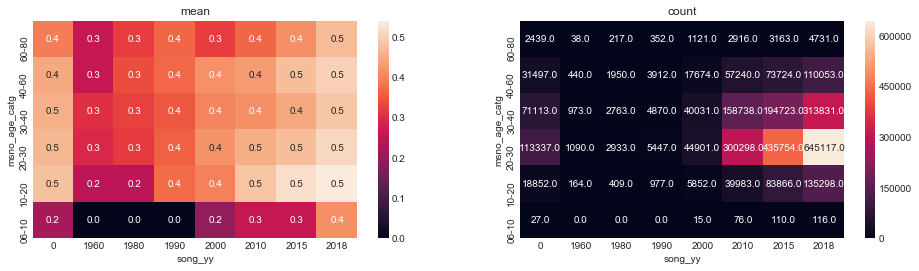

In [23]:
age_tick = ['06-10', '10-20', '20-30', '30-40', '40-60', '60-80']
age_tick.reverse()

# chop = stats.query("song_yy != '0' and msno_age_catg != '' and "
#                    "language != '-1' and language != '0' and "
#                    "genre_ids != ''")
chop = stats.query("msno_age_catg != ''")
utils_nb.heatmap(chop, 'msno_age_catg', 'song_yy', annot=True, ytick=age_tick, fmt='.1f')

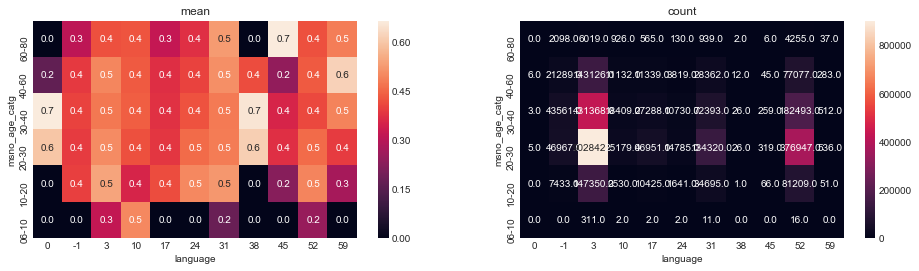

In [24]:
utils_nb.heatmap(chop, 'msno_age_catg', 'language', annot=True,
                 xtick=('0', '-1', '3', '10', '17', '24', '31', '38', '45', '52', '59'),
                 ytick=age_tick, fmt='.1f')

### Observation
- `song_yy = 0` 為不知年份的歌曲
- 總體來看, 年齡20 ~ 30歲的人數最多, 這在預料之中
- 歌曲年份越新越受歡迎, 不管年齡層
- 以1960年代以前的歌曲, 高年齡層的人偏愛的程度比其他年份多一些, 但趨勢上不是強烈的顯著, 畢竟因為高年齡使用人數太少
- `language = 3` 的人數是最多的, 喜好的程度也很高, KKBOX是華語為主的音樂平台, 可大膽猜測`language 3`應該是華語類, 從songs table查詢也確實如此

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
### 依照language個別檢視

language = -1


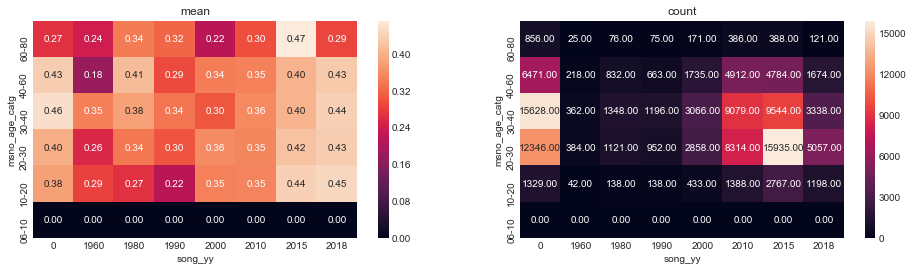

language = 0


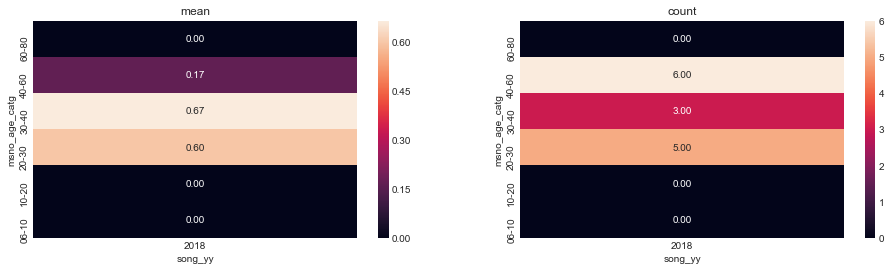

language = 3


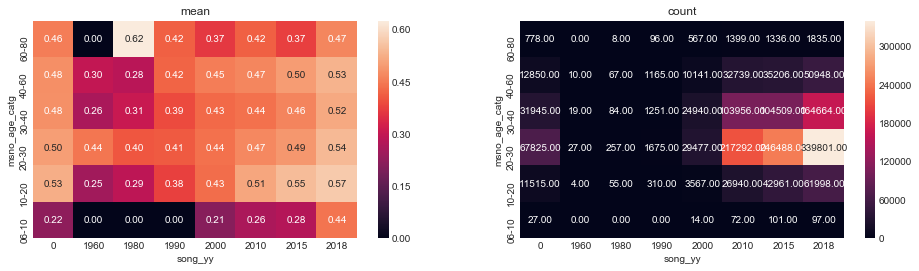

language = 10


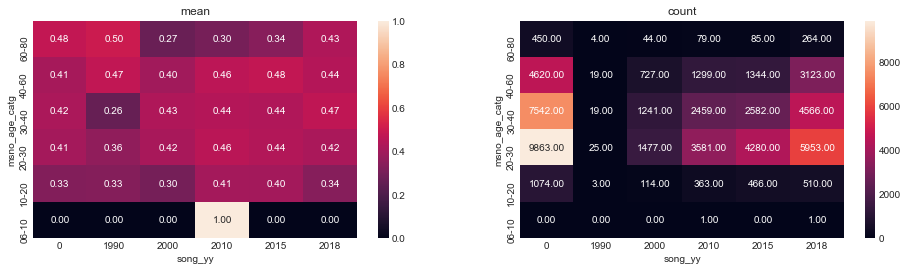

language = 17


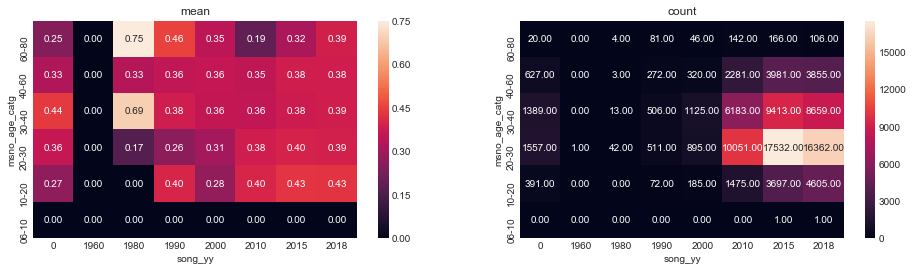

language = 24


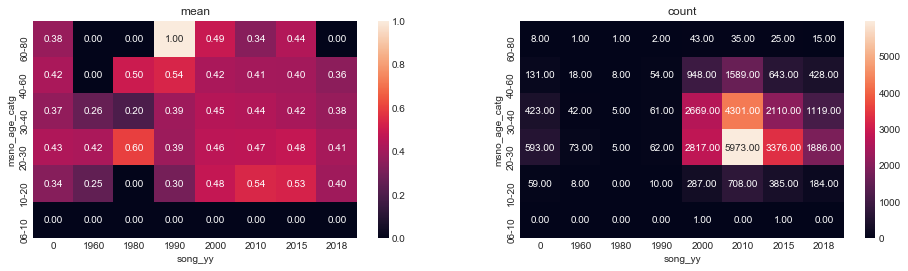

language = 31


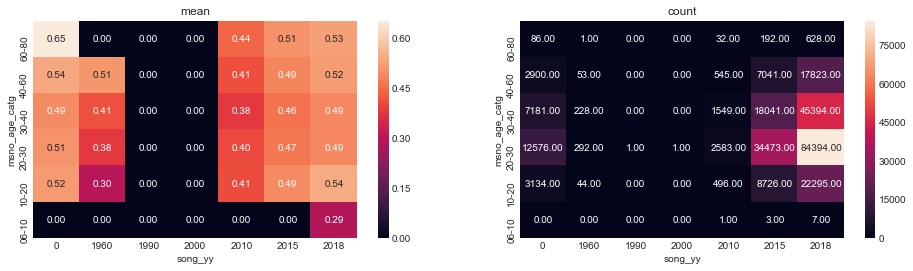

language = 38


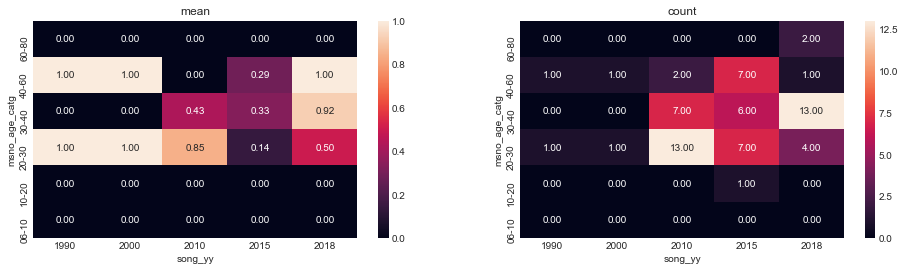

language = 45


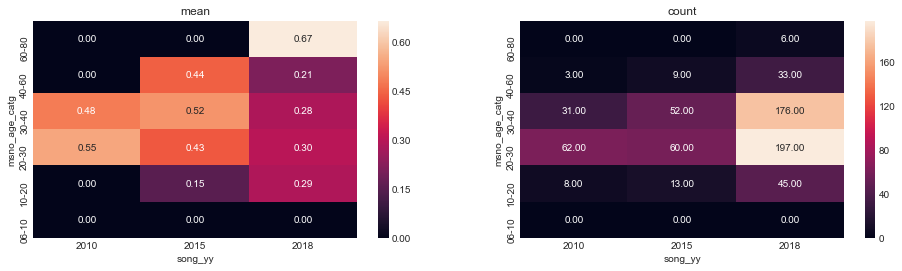

language = 52


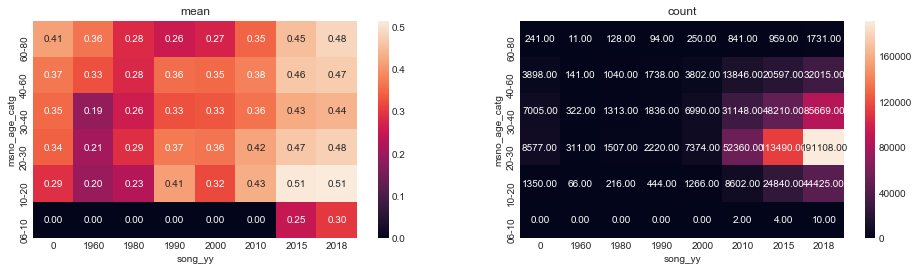

language = 59


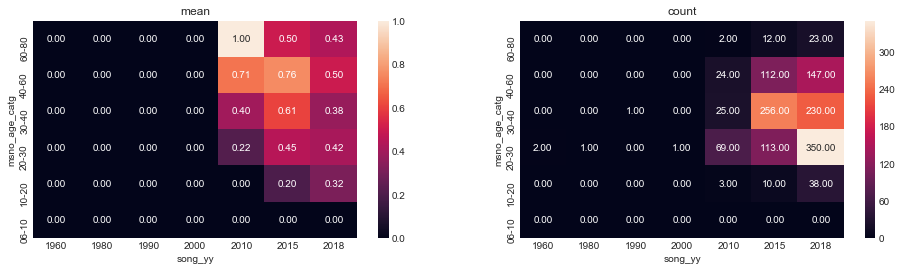

In [26]:
for lan in ('-1', '0', '3', '10', '17', '24',  '31', '38', '45', '52', '59'):
    print(f'language = {lan}')
    utils_nb.heatmap(chop.query(f"language == '{lan}'"), 'msno_age_catg', 'song_yy', annot=True, ytick=age_tick, fmt='.2f')

### Observation (自動忽略數量太少的部分)
- `language = 17`是日語歌, 1980年代的歌曲在`30-40`, `60~80`歲平均有增高, 也許和台灣日據時期有些關係, 但是考慮到人數太少, 所以不認為是顯著的
- `language = 45`是泰文歌, 沒有2010以前的年分的聽歌紀錄(但是songs table裡面是有的)
- `language = 24`的點擊數集中在2010年分, 從songs table可知是香港歌曲(這似乎有什麼特殊原因), `language = 38`似乎也是如此, 但是數量太少所以不認為是顯著的
---
<br/>
<br/>
看來大多數人聽歌的習慣會大約會停留在20 ~ 40歲之間, 聽老歌的人年齡層就會高一點, 而歌曲本身語言影響也是很顯著的, 是重要的feature


<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
再來是以`genre_ids`為主, 因為種類眾多, 只觀察數量在1萬以上的genres

In [88]:
genre_vc.shape

(22,)

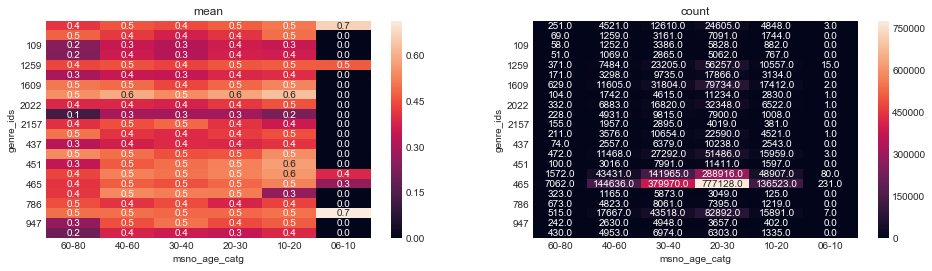

In [85]:
genre_vc = chop.genre_ids.value_counts()
genre_vc = genre_vc[genre_vc >= 20000].index.values
utils_nb.heatmap(chop[chop.genre_ids.isin(genre_vc)], 
                 'genre_ids', 'msno_age_catg', annot=True, xtick=age_tick, fmt='.1f')

### Observation
- 基本上除了數量集中在 `genre = 465` 是顯著的, 偏好的部分平均分布, 除了`60-80`歲的族群似乎不太喜歡`genre = 2122`的歌曲
- 備註: 在看偏好平均時都會和數量一起看, 例如數量太少卻有高偏好的, 這不算是顯著的

<br/>
<br/>
<br/>
## Data Clean, Data Type Fix

In [3]:
%%time
inp.Input.instance.clean('./data/train.csv')

2018-07-30 21:03:14,173 - trainer.input - INFO [line:30] - Clean start, is_serving: False
2018-07-30 21:03:37,306 - trainer.input - INFO [line:54] - Clean table members.
2018-07-30 21:03:37,852 - trainer.input - INFO [line:65] - Clean table songs.
2018-07-30 21:04:37,575 - trainer.input - INFO [line:84] - Clean take time 0:01:23.401771
Wall time: 1min 24s


### Filter Train Data and Split Train Valid

In [4]:
%%time
tr, vl = inp.Input.instance.split(data=data)

2018-07-30 21:04:38,611 - trainer.input - INFO [line:88] - Split start
2018-07-30 21:04:40,220 - trainer.input - INFO [line:108] - Msno data distribution 
count    30755.000000
mean       239.877028
std        314.130788
min          1.000000
25%         27.000000
50%        128.000000
75%        340.000000
max       5819.000000
dtype: float64

2018-07-30 21:04:40,224 - trainer.input - INFO [line:109] - Filter training data
2018-07-30 21:05:03,103 - trainer.input - INFO [line:117] - Split take time 0:00:24.490401
Wall time: 24.5 s




## Phase 1: Prepare,  Add Columns, Feature Engineering

In [5]:
%%time
inp.Input.instance.prepare(data=data, is_serving=False)

2018-07-30 21:05:03,563 - trainer.input - INFO [line:175] - Prepare start
2018-07-30 21:05:06,659 - trainer.input - INFO [line:188] - 
Do prepare_members
2018-07-30 21:05:12,456 - trainer.input - INFO [line:206] - processing msno_age_catg done, msno_age_num, msno_tenure ...
2018-07-30 21:05:13,779 - trainer.input - INFO [line:222] - processing msno_pos_query, msno_neg_query ...
2018-07-30 21:05:34,604 - trainer.input - INFO [line:141] - source_system_tab count done, take 0:00:05.675325
2018-07-30 21:05:40,727 - trainer.input - INFO [line:141] - source_screen_name count done, take 0:00:05.574319
2018-07-30 21:05:47,751 - trainer.input - INFO [line:141] - source_type count done, take 0:00:06.874394
2018-07-30 21:05:55,527 - trainer.input - INFO [line:141] - language count,mean done, take 0:00:07.612435
2018-07-30 21:06:26,214 - trainer.input - INFO [line:141] - artist_name count,mean done, take 0:00:30.631752
2018-07-30 21:07:02,436 - trainer.input - INFO [line:141] - composer count,mean

In [8]:
%%time
params = pd.Series({
    'fpath': './data/test.csv'
})
test_data = Ctrl.instance.transform(params)

2018-08-02 15:43:39,239 - trainer.input - INFO [line:30] - Clean start, is_serving: True
2018-08-02 15:43:43,939 - trainer.input - INFO [line:78] - Clean take time 0:00:04.698603
2018-08-02 15:43:43,941 - trainer.input - INFO [line:169] - Prepare start
2018-08-02 15:43:43,942 - trainer.input - INFO [line:193] - Prepare take time 0:00:00
2018-08-02 15:43:43,943 - trainer.input - INFO [line:354] - Transform start
2018-08-02 15:44:20,897 - trainer.input - INFO [line:369] - transform song_id, vocab_key: song_id ...
2018-08-02 15:44:23,426 - trainer.input - INFO [line:516] - transform take time 0:00:02.520772
2018-08-02 15:44:23,514 - trainer.input - INFO [line:369] - transform source_system_tab, vocab_key: source_system_tab ...
2018-08-02 15:44:23,765 - trainer.input - INFO [line:516] - transform take time 0:00:00.250330
2018-08-02 15:44:23,808 - trainer.input - INFO [line:369] - transform source_screen_name, vocab_key: source_screen_name ...
2018-08-02 15:44:24,052 - trainer.input - INFO 

## Fit
1. 記住feature狀態, 這裡選擇fit merge過後的fat table, 照理說fit profile table就好(像songs, members), 
雖然fit fat table資料會虛增造成效能慢, 但是有時候會去計算feature出現的頻率, 有些超冷門類別就乾脆transform成0就好, 
這邊從profile資料就無法做到, 這也是選擇fit fat table的原因

In [6]:
%%time
inp.Input.instance.fit('./data/processed/prepared/tr.pkl')

2018-07-30 21:16:45,163 - trainer.input - INFO [line:318] - Fit start
2018-07-30 21:17:22,499 - trainer.input - INFO [line:333] - fit msno ...
2018-07-30 21:17:23,763 - trainer.input - INFO [line:333] - fit song_id ...
2018-07-30 21:17:27,183 - trainer.input - INFO [line:333] - fit source_system_tab ...
2018-07-30 21:17:28,331 - trainer.input - INFO [line:333] - fit source_screen_name ...
2018-07-30 21:17:29,454 - trainer.input - INFO [line:333] - fit source_type ...
2018-07-30 21:17:30,707 - trainer.input - INFO [line:333] - fit city ...
2018-07-30 21:17:31,794 - trainer.input - INFO [line:333] - fit gender ...
2018-07-30 21:17:32,705 - trainer.input - INFO [line:333] - fit registered_via ...
2018-07-30 21:17:33,772 - trainer.input - INFO [line:333] - fit msno_age_catg ...
2018-07-30 21:17:34,691 - trainer.input - INFO [line:333] - fit language ...
2018-07-30 21:17:36,253 - trainer.input - INFO [line:333] - fit song_cc ...
2018-07-30 21:17:37,835 - trainer.input - INFO [line:333] - fi

h:\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2018-07-30 21:18:49,346 - trainer.input - INFO [line:345] - fit song_yy ...
2018-07-30 21:18:50,149 - trainer.input - INFO [line:345] - fit song_length ...
2018-07-30 21:18:51,094 - trainer.input - INFO [line:345] - fit song_pplrty ...
2018-07-30 21:18:51,892 - trainer.input - INFO [line:345] - fit song_clicks ...
2018-07-30 21:18:53,101 - trainer.input - INFO [line:351] - Fit take time 0:02:07.937318
Wall time: 2min 11s


## Transform
1. Trasnform 所有features為numeric, 這裡選擇transform profile table再去merge增加效能.

In [ ]:
%%time
inp.Input.instance.transform('./data/processed/prepared/tr.pkl')

2018-07-30 21:31:56,600 - trainer.input - INFO [line:361] - Transform start
2018-07-30 21:32:10,008 - trainer.input - INFO [line:392] - transform city, vocab_key: city ...
2018-07-30 21:32:10,046 - trainer.input - INFO [line:518] - transform take time 0:00:00.037002
2018-07-30 21:32:10,065 - trainer.input - INFO [line:392] - transform gender, vocab_key: gender ...
2018-07-30 21:32:10,069 - trainer.input - INFO [line:518] - transform take time 0:00:00.003000
2018-07-30 21:32:10,088 - trainer.input - INFO [line:392] - transform registered_via, vocab_key: registered_via ...
2018-07-30 21:32:10,091 - trainer.input - INFO [line:518] - transform take time 0:00:00.002000
2018-07-30 21:32:10,110 - trainer.input - INFO [line:392] - transform registration_init_time, vocab_key: registration_init_time ...
2018-07-30 21:32:10,113 - trainer.input - INFO [line:518] - transform take time 0:00:00.002000
2018-07-30 21:32:10,114 - trainer.input - INFO [line:392] - transform expiration_date, vocab_key: ex

h:\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2018-07-30 21:32:11,938 - trainer.input - INFO [line:518] - transform take time 0:00:01.787103
2018-07-30 21:32:12,035 - trainer.input - INFO [line:403] - transform msno_neg_query_hist, vocab_key: song_id ...
2018-07-30 21:32:13,694 - trainer.input - INFO [line:518] - transform take time 0:00:01.658095
2018-07-30 21:32:13,810 - trainer.input - INFO [line:403] - transform msno_artist_name_hist, vocab_key: artist_name ...
2018-07-30 21:32:14,783 - trainer.input - INFO [line:518] - transform take time 0:00:00.973055
2018-07-30 21:32:14,808 - trainer.input - INFO [line:403] - transform msno_composer_hist, vocab_key: composer ...
2018-07-30 21:32:16,332 - trainer.input - INFO [line:518] - transform take time 0:00:01.524087
2018-07-30 21:32:16,382 - trainer.input - INFO [line:403] - transform msno_genre_ids_hist, vocab_key: genre_ids ...
2018-07-30 21:32:16,575 - trainer.input - INFO [line:518] - transform take time 0:00:00.192011
2018-07-30 21:32:16,581 - trainer.input - INFO [line:403] - t


## Train

### DNN Model

In [2]:
%%time
p = app_conf.instance
tf.reset_default_graph()
service.Service.instance.train(model_name='dnn', reset=True)

2018-08-08 16:01:55,102 - trainer.service - INFO [line:23] - Delete job_dir D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm to avoid re-use
2018-08-08 16:01:55,122 - trainer.service - INFO [line:29] - Model: dnn, model_dir: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm
2018-08-08 16:01:55,619 - trainer.service - INFO [line:47] - Use model dnn: <trainer.model.Model object at 0x000002514AA5FAC8>
2018-08-08 16:01:55,620 - trainer.service - INFO [line:48] - Model Directory: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm
2018-08-08 16:01:55,621 - BestScoreExporter - INFO [line:398] - BestScoreExporter init, last best eval is None
2018-08-08 16:01:55,622 - trainer.service - INFO [line:58] - read train file into memory
2018-08-08 16:02:38,185 - trainer.service - INFO [line:77] - read valid file into memory
2018-08-08 16:02:53,905 - trainer.model - INFO [line:283] - creating a custom Estimator
INFO:tensorflow:Using config:

INFO:tensorflow:Loss for final step: 0.5196766.
2018-08-08 16:20:21,259 - tensorflow - INFO [line:115] - Loss for final step: 0.5196766.
2018-08-08 16:20:21,299 - trainer.input - INFO [line:658] - 
2018-08-08 16:20:21,299 - trainer.input - INFO [line:659] - * data input_fn:
2018-08-08 16:20:21,299 - trainer.input - INFO [line:660] - ================
2018-08-08 16:20:21,299 - trainer.input - INFO [line:661] - Mode: eval
2018-08-08 16:20:21,299 - trainer.input - INFO [line:662] - Batch size: 1000
2018-08-08 16:20:21,299 - trainer.input - INFO [line:663] - Epoch count: 1
2018-08-08 16:20:21,299 - trainer.input - INFO [line:664] - Thread count: 8
2018-08-08 16:20:21,309 - trainer.input - INFO [line:665] - Shuffle: False
2018-08-08 16:20:21,309 - trainer.input - INFO [line:666] - ================
2018-08-08 16:20:21,309 - trainer.input - INFO [line:667] - 
INFO:tensorflow:Calling model_fn.
2018-08-08 16:20:21,480 - tensorflow - INFO [line:115] - Calling model_fn.
2018-08-08 16:20:21,480 - t

2018-08-08 16:29:54,277 - trainer.input - INFO [line:663] - Epoch count: 1
2018-08-08 16:29:54,277 - trainer.input - INFO [line:664] - Thread count: 8
2018-08-08 16:29:54,277 - trainer.input - INFO [line:665] - Shuffle: True
2018-08-08 16:29:54,277 - trainer.input - INFO [line:666] - ================
2018-08-08 16:29:54,277 - trainer.input - INFO [line:667] - 
2018-08-08 16:29:54,277 - trainer.input - INFO [line:671] - shuffle data manually.
INFO:tensorflow:Calling model_fn.
2018-08-08 16:30:27,798 - tensorflow - INFO [line:115] - Calling model_fn.
2018-08-08 16:30:27,800 - trainer.model - INFO [line:156] - mode: train, is_train: True, use dropout: False
2018-08-08 16:30:33,422 - trainer.model - INFO [line:82] - self.members_feature: Tensor("members/members_feature:0", shape=(?, 175), dtype=float32)
2018-08-08 16:30:33,628 - trainer.model - INFO [line:124] - self.songs_feature: Tensor("songs/songs_feature:0", shape=(?, 120), dtype=float32)
2018-08-08 16:30:33,628 - trainer.model - INFO

2018-08-08 16:53:55,426 - tensorflow - INFO [line:115] - Evaluation [343/492]
INFO:tensorflow:Evaluation [392/492]
2018-08-08 16:54:47,986 - tensorflow - INFO [line:115] - Evaluation [392/492]
INFO:tensorflow:Evaluation [441/492]
2018-08-08 16:55:40,026 - tensorflow - INFO [line:115] - Evaluation [441/492]
INFO:tensorflow:Evaluation [490/492]
2018-08-08 16:56:30,725 - tensorflow - INFO [line:115] - Evaluation [490/492]
INFO:tensorflow:Evaluation [492/492]
2018-08-08 16:56:33,087 - tensorflow - INFO [line:115] - Evaluation [492/492]
INFO:tensorflow:Finished evaluation at 2018-08-08-08:56:33
2018-08-08 16:56:33,136 - tensorflow - INFO [line:115] - Finished evaluation at 2018-08-08-08:56:33
INFO:tensorflow:Saving dict for global step 1382: auc = 0.7635357, global_step = 1382, loss = 0.592625
2018-08-08 16:56:33,136 - tensorflow - INFO [line:115] - Saving dict for global step 1382: auc = 0.7635357, global_step = 1382, loss = 0.592625
INFO:tensorflow:Saving 'checkpoint_path' summary for glo

2018-08-08 17:14:02,549 - trainer.model - INFO [line:124] - self.songs_feature: Tensor("songs/songs_feature:0", shape=(?, 120), dtype=float32)
2018-08-08 17:14:02,556 - trainer.model - INFO [line:133] - self.context_features: Tensor("context/context_features:0", shape=(?, 9), dtype=float32)
2018-08-08 17:14:02,675 - trainer.model - INFO [line:166] - net: Tensor("dnn/concat:0", shape=(?, 48), dtype=float32)
INFO:tensorflow:Done calling model_fn.
2018-08-08 17:14:02,876 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-08-09:14:02
2018-08-08 17:14:02,906 - tensorflow - INFO [line:115] - Starting evaluation at 2018-08-08-09:14:02
INFO:tensorflow:Graph was finalized.
2018-08-08 17:14:03,066 - tensorflow - INFO [line:115] - Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-2100
2018-08-08 17:14:03,095 - tensorflow - INFO [line:115] - Restoring p

INFO:tensorflow:Done calling model_fn.
2018-08-08 17:23:55,380 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
2018-08-08 17:23:55,386 - tensorflow - INFO [line:115] - Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
2018-08-08 17:23:55,670 - tensorflow - INFO [line:115] - Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-2100
2018-08-08 17:23:55,906 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-2100
INFO:tensorflow:Running local_init_op.
2018-08-08 17:23:56,360 - tensorflow - INFO [line:115] - Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2018-08-08 17:23:56,406 - tensorflow - INFO [line:115] - Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2100 into D:\Python\notebook\ml_specialized\kkbox/m

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2826: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-2826
2018-08-08 17:49:51,616 - tensorflow - INFO [line:115] - Saving 'checkpoint_path' summary for global step 2826: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-2826
2018-08-08 17:49:51,626 - BestScoreExporter - INFO [line:419] - eval_result: {'auc': 0.77321523, 'loss': 0.57147735, 'global_step': 2826}
2018-08-08 17:49:51,626 - BestScoreExporter - INFO [line:423] - clean export_path: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\export\estimator
2018-08-08 17:49:51,640 - BestScoreExporter - INFO [line:412] - Persistent best eval: 0.5714773535728455
2018-08-08 17:49:51,642 - BestScoreExporter - INFO [line:434] - nice eval loss: 0.5714773535728455, export to pb
2018-08-08 17:49:51,648 - trainer.input - INFO [line:553] - use json_serving_input_fn !
INFO:tensorflow:Calling mode

2018-08-08 18:03:01,197 - tensorflow - INFO [line:115] - loss = 0.4942575, step = 3326 (160.492 sec)
INFO:tensorflow:global_step/sec: 0.709325
2018-08-08 18:05:22,140 - tensorflow - INFO [line:115] - global_step/sec: 0.709325
INFO:tensorflow:loss = 0.4876956, step = 3426 (140.963 sec)
2018-08-08 18:05:22,160 - tensorflow - INFO [line:115] - loss = 0.4876956, step = 3426 (140.963 sec)
INFO:tensorflow:Saving checkpoints for 3486 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
2018-08-08 18:07:13,553 - tensorflow - INFO [line:115] - Saving checkpoints for 3486 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
INFO:tensorflow:Loss for final step: 0.49407068.
2018-08-08 18:07:26,890 - tensorflow - INFO [line:115] - Loss for final step: 0.49407068.
2018-08-08 18:07:26,997 - trainer.input - INFO [line:658] - 
2018-08-08 18:07:27,002 - trainer.input - INFO [line:659] - * data input_fn:
2018-08-08 18:07:27,003 - train

INFO:tensorflow:loss = 0.49669933, step = 3486
2018-08-08 18:29:33,394 - tensorflow - INFO [line:115] - loss = 0.49669933, step = 3486
INFO:tensorflow:global_step/sec: 0.343305
2018-08-08 18:34:24,680 - tensorflow - INFO [line:115] - global_step/sec: 0.343305
INFO:tensorflow:loss = 0.48786762, step = 3586 (293.113 sec)
2018-08-08 18:34:26,507 - tensorflow - INFO [line:115] - loss = 0.48786762, step = 3586 (293.113 sec)
INFO:tensorflow:global_step/sec: 0.343007
2018-08-08 18:39:16,219 - tensorflow - INFO [line:115] - global_step/sec: 0.343007
INFO:tensorflow:loss = 0.5017557, step = 3686 (291.470 sec)
2018-08-08 18:39:17,977 - tensorflow - INFO [line:115] - loss = 0.5017557, step = 3686 (291.470 sec)
INFO:tensorflow:global_step/sec: 0.345789
2018-08-08 18:44:05,414 - tensorflow - INFO [line:115] - global_step/sec: 0.345789
INFO:tensorflow:loss = 0.49462235, step = 3786 (289.173 sec)
2018-08-08 18:44:07,150 - tensorflow - INFO [line:115] - loss = 0.49462235, step = 3786 (289.173 sec)
INF

2018-08-08 19:05:17,114 - tensorflow - INFO [line:115] - Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-3821
2018-08-08 19:05:17,189 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-3821
INFO:tensorflow:Assets added to graph.
2018-08-08 19:05:17,267 - tensorflow - INFO [line:115] - Assets added to graph.
INFO:tensorflow:No assets to write.
2018-08-08 19:05:17,282 - tensorflow - INFO [line:115] - No assets to write.
INFO:tensorflow:SavedModel written to: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\export\estimator\temp-b'1533726316'\saved_model.pb
2018-08-08 19:05:17,821 - tensorflow - INFO [line:115] - SavedModel written to: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\export\estimator\temp-b'1533726316'\saved_model.pb
2018

INFO:tensorflow:Running local_init_op.
2018-08-08 19:19:10,886 - tensorflow - INFO [line:115] - Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2018-08-08 19:19:10,908 - tensorflow - INFO [line:115] - Done running local_init_op.
INFO:tensorflow:Evaluation [49/492]
2018-08-08 19:20:13,066 - tensorflow - INFO [line:115] - Evaluation [49/492]
INFO:tensorflow:Evaluation [98/492]
2018-08-08 19:21:08,750 - tensorflow - INFO [line:115] - Evaluation [98/492]
INFO:tensorflow:Evaluation [147/492]
2018-08-08 19:22:02,692 - tensorflow - INFO [line:115] - Evaluation [147/492]
INFO:tensorflow:Evaluation [196/492]
2018-08-08 19:22:57,067 - tensorflow - INFO [line:115] - Evaluation [196/492]
INFO:tensorflow:Evaluation [245/492]
2018-08-08 19:23:49,342 - tensorflow - INFO [line:115] - Evaluation [245/492]
INFO:tensorflow:Evaluation [294/492]
2018-08-08 19:24:42,202 - tensorflow - INFO [line:115] - Evaluation [294/492]
INFO:tensorflow:Evaluation [343/492]
2018-08-08 19:25:33,438 - ten

### Neural(DNN) + MF Model

In [2]:
%%time
p = app_conf.instance
tf.reset_default_graph()
service.Service.instance.train(model_name='neu_mf', reset=False)

2018-08-08 11:50:30,624 - trainer.service - INFO [line:23] - Delete job_dir D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding to avoid re-use
2018-08-08 11:50:30,628 - trainer.service - INFO [line:28] - Model: neu_mf, model_dir: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding
2018-08-08 11:50:31,040 - trainer.service - INFO [line:46] - Use model neu_mf: <trainer.model.NeuMFModel object at 0x000001E49BB5EB70>
2018-08-08 11:50:31,042 - trainer.service - INFO [line:47] - Model Directory: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding
2018-08-08 11:50:31,043 - BestScoreExporter - INFO [line:403] - BestScoreExporter init, last best eval is None
2018-08-08 11:50:31,043 - trainer.service - INFO [line:57] - read train file into memory
2018-08-08 11:51:12,005 - trainer.service - INFO [line:76] - read valid file into memory
2018-08-08 11:51:26,477 - trainer.model - INFO [line:287] - creating a custom Estimat

2018-08-08 12:08:56,845 - trainer.input - INFO [line:659] - * data input_fn:
2018-08-08 12:08:56,845 - trainer.input - INFO [line:660] - ================
2018-08-08 12:08:56,845 - trainer.input - INFO [line:661] - Mode: eval
2018-08-08 12:08:56,845 - trainer.input - INFO [line:662] - Batch size: 1000
2018-08-08 12:08:56,845 - trainer.input - INFO [line:663] - Epoch count: 1
2018-08-08 12:08:56,845 - trainer.input - INFO [line:664] - Thread count: 8
2018-08-08 12:08:56,845 - trainer.input - INFO [line:665] - Shuffle: False
2018-08-08 12:08:56,845 - trainer.input - INFO [line:666] - ================
2018-08-08 12:08:56,854 - trainer.input - INFO [line:667] - 
INFO:tensorflow:Calling model_fn.
2018-08-08 12:08:57,025 - tensorflow - INFO [line:115] - Calling model_fn.
2018-08-08 12:08:57,025 - trainer.model - INFO [line:305] - mode: eval, is_train: False, use dropout: False
2018-08-08 12:08:57,769 - trainer.model - INFO [line:79] - self.members_feature: Tensor("members/members_feature:0", 

2018-08-08 12:19:03,924 - trainer.input - INFO [line:665] - Shuffle: True
2018-08-08 12:19:03,924 - trainer.input - INFO [line:666] - ================
2018-08-08 12:19:03,924 - trainer.input - INFO [line:667] - 
2018-08-08 12:19:03,924 - trainer.input - INFO [line:671] - shuffle data manually.
INFO:tensorflow:Calling model_fn.
2018-08-08 12:19:39,262 - tensorflow - INFO [line:115] - Calling model_fn.
2018-08-08 12:19:39,273 - trainer.model - INFO [line:305] - mode: train, is_train: True, use dropout: False
2018-08-08 12:19:39,678 - trainer.model - INFO [line:79] - self.members_feature: Tensor("members/members_feature:0", shape=(?, 175), dtype=float32)
2018-08-08 12:19:39,854 - trainer.model - INFO [line:121] - self.songs_feature: Tensor("songs/songs_feature:0", shape=(?, 120), dtype=float32)
2018-08-08 12:19:39,864 - trainer.model - INFO [line:130] - self.context_features: Tensor("context/context_features:0", shape=(?, 9), dtype=float32)
INFO:tensorflow:Done calling model_fn.
2018-08-0

INFO:tensorflow:Evaluation [392/492]
2018-08-08 12:44:32,815 - tensorflow - INFO [line:115] - Evaluation [392/492]
INFO:tensorflow:Evaluation [441/492]
2018-08-08 12:45:28,582 - tensorflow - INFO [line:115] - Evaluation [441/492]
INFO:tensorflow:Evaluation [490/492]
2018-08-08 12:46:21,122 - tensorflow - INFO [line:115] - Evaluation [490/492]
INFO:tensorflow:Evaluation [492/492]
2018-08-08 12:46:23,492 - tensorflow - INFO [line:115] - Evaluation [492/492]
INFO:tensorflow:Finished evaluation at 2018-08-08-04:46:23
2018-08-08 12:46:23,568 - tensorflow - INFO [line:115] - Finished evaluation at 2018-08-08-04:46:23
INFO:tensorflow:Saving dict for global step 1359: auc = 0.7704302, global_step = 1359, loss = 0.5803378
2018-08-08 12:46:23,571 - tensorflow - INFO [line:115] - Saving dict for global step 1359: auc = 0.7704302, global_step = 1359, loss = 0.5803378
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1359: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no

2018-08-08 13:04:01,889 - tensorflow - INFO [line:115] - Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding\model.ckpt-1934
2018-08-08 13:04:01,982 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding\model.ckpt-1934
INFO:tensorflow:Running local_init_op.
2018-08-08 13:04:02,380 - tensorflow - INFO [line:115] - Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2018-08-08 13:04:02,414 - tensorflow - INFO [line:115] - Done running local_init_op.
INFO:tensorflow:Evaluation [49/492]
2018-08-08 13:05:09,841 - tensorflow - INFO [line:115] - Evaluation [49/492]
INFO:tensorflow:Evaluation [98/492]
2018-08-08 13:06:07,643 - tensorflow - INFO [line:115] - Evaluation [98/492]
INFO:tensorflow:Evaluation [147/492]
2018-08-08 13:07:04,631 - tensorflow - INFO [line:115] - Evaluation [147/492]
INFO:tensorflow:Eval

2018-08-08 13:31:00,718 - trainer.input - INFO [line:658] - 
2018-08-08 13:31:00,718 - trainer.input - INFO [line:659] - * data input_fn:
2018-08-08 13:31:00,718 - trainer.input - INFO [line:660] - ================
2018-08-08 13:31:00,718 - trainer.input - INFO [line:661] - Mode: eval
2018-08-08 13:31:00,718 - trainer.input - INFO [line:662] - Batch size: 1000
2018-08-08 13:31:00,718 - trainer.input - INFO [line:663] - Epoch count: 1
2018-08-08 13:31:00,718 - trainer.input - INFO [line:664] - Thread count: 8
2018-08-08 13:31:00,718 - trainer.input - INFO [line:665] - Shuffle: False
2018-08-08 13:31:00,718 - trainer.input - INFO [line:666] - ================
2018-08-08 13:31:00,728 - trainer.input - INFO [line:667] - 
INFO:tensorflow:Calling model_fn.
2018-08-08 13:31:00,908 - tensorflow - INFO [line:115] - Calling model_fn.
2018-08-08 13:31:00,908 - trainer.model - INFO [line:305] - mode: eval, is_train: False, use dropout: False
2018-08-08 13:31:01,208 - trainer.model - INFO [line:79]

2018-08-08 13:49:40,159 - tensorflow - INFO [line:115] - loss = 0.48771203, step = 2879 (173.739 sec)
INFO:tensorflow:global_step/sec: 0.418253
2018-08-08 13:53:39,223 - tensorflow - INFO [line:115] - global_step/sec: 0.418253
INFO:tensorflow:loss = 0.4543771, step = 2979 (239.145 sec)
2018-08-08 13:53:39,303 - tensorflow - INFO [line:115] - loss = 0.4543771, step = 2979 (239.145 sec)
INFO:tensorflow:Saving checkpoints for 3079 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding\model.ckpt.
2018-08-08 13:55:59,169 - tensorflow - INFO [line:115] - Saving checkpoints for 3079 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding\model.ckpt.
INFO:tensorflow:global_step/sec: 0.515742
2018-08-08 13:56:53,109 - tensorflow - INFO [line:115] - global_step/sec: 0.515742
INFO:tensorflow:loss = 0.48789775, step = 3079 (193.839 sec)
2018-08-08 13:56:53,143 - tensorflow - INFO [line:115] - loss = 0.48789775, step = 3079 (193.839 sec)
INFO:

INFO:tensorflow:Running local_init_op.
2018-08-08 14:08:52,678 - tensorflow - INFO [line:115] - Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2018-08-08 14:08:52,736 - tensorflow - INFO [line:115] - Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3123 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding\model.ckpt.
2018-08-08 14:08:55,738 - tensorflow - INFO [line:115] - Saving checkpoints for 3123 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding\model.ckpt.
INFO:tensorflow:loss = 0.5004207, step = 3123
2018-08-08 14:09:20,901 - tensorflow - INFO [line:115] - loss = 0.5004207, step = 3123
INFO:tensorflow:global_step/sec: 0.615542
2018-08-08 14:12:03,307 - tensorflow - INFO [line:115] - global_step/sec: 0.615542
INFO:tensorflow:loss = 0.49417496, step = 3223 (162.450 sec)
2018-08-08 14:12:03,337 - tensorflow - INFO [line:115] - loss = 0.49417496, step = 3223 (162.450 sec)
INFO:tensorf

2018-08-08 14:35:26,590 - trainer.input - INFO [line:671] - shuffle data manually.
INFO:tensorflow:Calling model_fn.
2018-08-08 14:36:04,604 - tensorflow - INFO [line:115] - Calling model_fn.
2018-08-08 14:36:04,611 - trainer.model - INFO [line:305] - mode: train, is_train: True, use dropout: False
2018-08-08 14:36:04,989 - trainer.model - INFO [line:79] - self.members_feature: Tensor("members/members_feature:0", shape=(?, 175), dtype=float32)
2018-08-08 14:36:05,189 - trainer.model - INFO [line:121] - self.songs_feature: Tensor("songs/songs_feature:0", shape=(?, 120), dtype=float32)
2018-08-08 14:36:05,198 - trainer.model - INFO [line:130] - self.context_features: Tensor("context/context_features:0", shape=(?, 9), dtype=float32)
INFO:tensorflow:Done calling model_fn.
2018-08-08 14:36:14,256 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
2018-08-08 14:36:14,260 - tensorflow - INFO [line:115] - Create CheckpointSaverHook.
INFO:tensorf

2018-08-08 15:03:41,872 - BestScoreExporter - INFO [line:447] - bad eval loss: 0.5801665782928467
2018-08-08 15:03:41,914 - trainer.input - INFO [line:658] - 
2018-08-08 15:03:41,915 - trainer.input - INFO [line:659] - * data input_fn:
2018-08-08 15:03:41,916 - trainer.input - INFO [line:660] - ================
2018-08-08 15:03:41,917 - trainer.input - INFO [line:661] - Mode: train
2018-08-08 15:03:41,918 - trainer.input - INFO [line:662] - Batch size: 1000
2018-08-08 15:03:41,919 - trainer.input - INFO [line:663] - Epoch count: 1
2018-08-08 15:03:41,920 - trainer.input - INFO [line:664] - Thread count: 8
2018-08-08 15:03:41,921 - trainer.input - INFO [line:665] - Shuffle: True
2018-08-08 15:03:41,921 - trainer.input - INFO [line:666] - ================
2018-08-08 15:03:41,922 - trainer.input - INFO [line:667] - 
2018-08-08 15:03:41,923 - trainer.input - INFO [line:671] - shuffle data manually.
INFO:tensorflow:Calling model_fn.
2018-08-08 15:04:17,097 - tensorflow - INFO [line:115] - C

2018-08-08 15:23:36,215 - BestScoreExporter - INFO [line:424] - eval_result: {'auc': 0.77283657, 'loss': 0.5840498, 'global_step': 4358}
2018-08-08 15:23:36,215 - BestScoreExporter - INFO [line:447] - bad eval loss: 0.5840498208999634
Wall time: 3h 33min 10s


## Protocol buffer file inspection
- Use saved_model_cli to inspect the protocol buff schema

In [48]:
export_dir = service.Service.instance.find_latest_expdir('neu_mf')
print( utils.cmd(f'saved_model_cli show --dir {export_dir}') )

The given SavedModel contains the following tag-sets:
serve



In [49]:
export_dir = service.Service.instance.find_latest_expdir('neu_mf')
print( utils.cmd(f'saved_model_cli show --dir {export_dir} --tag_set serve') )

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "outputs"
SignatureDef key: "serving_default"



In [61]:
export_dir = service.Service.instance.find_latest_expdir('neu_mf')
command = f'saved_model_cli show --dir {export_dir} --tag_set serve --signature_def outputs'
print( utils.cmd(command) )

The given SavedModel SignatureDef contains the following input(s):
  inputs['artist_name'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: artist_name:0
  inputs['city'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: city:0
  inputs['composer'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: composer:0
  inputs['expiration_date'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: expiration_date:0
  inputs['gender'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: gender:0
  inputs['genre_ids'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: genre_ids:0
  inputs['language'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: language:0
  inputs['lyricist'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: lyricist:0
  inputs['msno_age_catg'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: msno_age_catg:0
  inputs['msno_age_num']

## Serving
1. 系統接受的Raw data之後要經過轉換才能丟進Model裡面預測, 基本動作跟Training時一樣, 少了Fit的Phase
    - Clean: 處理Missing value, drop不需要的欄位
    - Prepare: 增加跟Training時一樣的欄位(Feature Engineering時增加的), 資料Merge
    - Transform: 轉換Column value, 連續變數的Normalize, 類別變數的one hot encoding

In [2]:
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))

2018-08-08 09:51:17,685 - trainer.input - INFO [line:30] - Clean start, is_serving: True
2018-08-08 09:51:21,935 - trainer.input - INFO [line:78] - Clean take time 0:00:04.249441
2018-08-08 09:51:21,937 - trainer.input - INFO [line:169] - Prepare start
2018-08-08 09:51:21,938 - trainer.input - INFO [line:193] - Prepare take time 0:00:00
2018-08-08 09:51:21,939 - trainer.input - INFO [line:354] - Transform start
2018-08-08 09:51:55,809 - trainer.input - INFO [line:369] - transform song_id, vocab_key: song_id ...
2018-08-08 09:51:57,736 - trainer.input - INFO [line:516] - transform take time 0:00:01.919002
2018-08-08 09:51:57,815 - trainer.input - INFO [line:369] - transform source_system_tab, vocab_key: source_system_tab ...
2018-08-08 09:51:58,044 - trainer.input - INFO [line:516] - transform take time 0:00:00.227396
2018-08-08 09:51:58,087 - trainer.input - INFO [line:369] - transform source_screen_name, vocab_key: source_screen_name ...
2018-08-08 09:51:58,325 - trainer.input - INFO 

In [3]:
test_df.head()

,city,gender,registered_via,registration_init_time,expiration_date,msno_age_catg,msno_age_num,msno_tenure,msno_pos_query_hist,msno_pos_query_count,...,song_registered_via_count,song_source_screen_name_hist,song_source_screen_name_count,song_source_system_tab_hist,song_source_system_tab_count,song_source_type_hist,song_source_type_count,source_system_tab,source_screen_name,source_type
0,1,0,2,0.917716,0.023812,0,-0.147597,-0.892480,"(3299, 5683, 501, 5471, 305, 4151, 45, 8743, 3...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(48, 123, 196, 327)","(0, 3, 6, 7, 11, 12, 1, 10, 17, 2, 9, 4, 5)","(2, 3, 4, 5, 8, 12, 14, 14, 28, 39, 49, 64, 452)","(0, 2, 6, 5, 1, 4, 3, 8)","(1, 1, 6, 14, 28, 67, 84, 493)","(0, 4, 9, 1, 3, 2, 6, 7, 8, 5)","(1, 7, 14, 15, 35, 35, 49, 59, 146, 333)",1,1,1
1,1,0,2,0.917716,0.023812,0,-0.147597,-0.892480,"(3299, 5683, 501, 5471, 305, 4151, 45, 8743, 3...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(11, 683, 1042, 2074, 2280)","(0, 3, 6, 8, 7, 11, 12, 1, 10, 17, 2, 9, 4, 5,...","(9, 10, 18, 19, 69, 76, 88, 91, 123, 150, 278,...","(0, 2, 6, 5, 1, 7, 4, 3, 8)","(2, 3, 22, 123, 151, 164, 300, 2165, 3160)","(0, 4, 11, 9, 1, 3, 12, 2, 6, 7, 8, 5, 10)","(2, 4, 9, 25, 35, 66, 115, 154, 170, 427, 843,...",1,1,1
2,1,0,4,1.165789,-2.241439,0,-0.147597,-1.399622,"(197, 34, 67, 66, 206, 1665, 2, 1628, 97315, 5...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(2, 3)","(6, 7, 1)","(1, 2, 2)","(2, 1, 3)","(1, 2, 2)","(1, 8, 5)","(1, 2, 2)",2,0,8
3,16,1,1,-1.937859,-1.048001,2,0.315310,1.767792,"(1043, 985, 9623, 6075, 5783, 8102, 18720, 769...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(2, 5, 5, 19)","(0, 1, 4)","(1, 4, 26)","(2, 6, 1, 4)","(1, 1, 3, 26)","(0, 1, 3, 6)","(1, 1, 3, 26)",4,4,6
4,16,1,1,-1.937859,-1.048001,2,0.315310,1.767792,"(1043, 985, 9623, 6075, 5783, 8102, 18720, 769...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"(1, 1, 3)","(3, 1, 4)","(1, 2, 2)","(1, 4, 3)","(1, 1, 3)","(4, 3, 6)","(1, 2, 2)",4,4,6


In [52]:
%%time
params = pd.Series({
    'datasource': test_df[:10000],
    'is_src_file': False
})
pred = Ctrl.instance.local_predict(params)
print(pred)

INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding/export/estimator/1533544404\variables\variables
2018-08-08 10:47:17,306 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_no_share_embedding/export/estimator/1533544404\variables\variables
2018-08-08 10:47:17,428 - trainer.service - INFO [line:135] - Total 10000 to predict ...
2018-08-08 10:47:17,537 - trainer.service - INFO [line:131] - pandas Apply testing ...
2018-08-08 10:47:18,971 - trainer.service - INFO [line:129] - 1000/10000 predicted ... 
2018-08-08 10:47:19,994 - trainer.service - INFO [line:129] - 2000/10000 predicted ... 
2018-08-08 10:47:21,009 - trainer.service - INFO [line:129] - 3000/10000 predicted ... 
2018-08-08 10:47:22,057 - trainer.service - INFO [line:129] - 4000/10000 predicted ... 
2018-08-08 10:47:23,273 - trainer.service - INFO [line:129] - 5000/10000 predicted ... 
2018-08

## Notes
從上述Serving Data轉換過後的資料, 我們用了很多Multivariate的欄位(grid裡面是array型態, 不是單一value), 這在處理資料時會花費不少時間和系統資源, 所以預測時間會稍微拉長, 上面只顯示前一萬筆的預測就需要11秒的時間
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
## Deply to ML-Engine for Prediction
- Set environ variable to read the api key json file: 
    - In trainer/app_conf.py, `Config.api_key_path` set the API key json path to acquire the access to any of GCP service

In [55]:
%%time
Ctrl.instance.set_client_secret()

2018-08-08 11:02:16,972 - trainer.ctrl - INFO [line:24] - Locate credential path [C:/Users/gary/client_secret.json]
Wall time: 2 ms


In [58]:
%%time
p = pd.Series({
    # `bucket_name` and `prefix` tell Where to place the model on cloud ==> gs://{bucket_name}/{prefix}
    'bucket_name': 'ml-specialized',
    'prefix': 'models/kkbox',
    'model_path': service.Service.instance.find_latest_expdir('neu_mf'),
})
Ctrl.instance.upload_model(p)

2018-08-08 11:25:15,863 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\kkbox\models\kkbox_neumf_no_share_embedding\export\estimator\1533544404/saved_model.pb to models/kkbox/saved_model.pb
2018-08-08 11:25:16,363 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\kkbox\models\kkbox_neumf_no_share_embedding\export\estimator\1533544404\variables/variables.data-00000-of-00001 to models/kkbox/variables/variables.data-00000-of-00001


KeyboardInterrupt: 

In [40]:
df = pd.DataFrame({'composer_list': data.composer_list.dropna().values, 
                   'len': data.composer_list.dropna().map(len).values})
print(df.head())
df.loc[df.len.idxmax()].composer_list

                               composer_list  len
0                     (Dan Smith, Mark Crew)    2
1    (N. Jones、W. Adams、J. Lordan、D. Ingle,)    1
2                           (Kwadwo Donkoh,)    1
3  (Brett Young, Justin Ebach, Kelly Archer)    3
4                 (Adnan Khan, Sidney Selby)    2


('1011,Kenny Rogers,Roger Bowling',
 '139,G.E.M.鄧紫棋,Kaci Brown',
 '139,Oldies 101,William Mickey Stevenson',
 '947,Music-Themes,,,-1\nXPGjUo/wPuYRoFYVB25kQ9TX5zP6Izcllmez7PPXB4I=,241673,465,Janet Jackson,Janet Jackson',
 'Aaron Gillespie',
 'Brian Carroll,,52\n0KjXAae7rj9kfrIGhAoYBWJoQBqjtzTQMKMprbnStrs=,229506,,Monday Kiz,,,31\nvoMgKcLbhYr1GIsEuMvT+Rjkib1qvY4WPSmw/mc8j1c=,402703,940,Guy Sweens,,,-1\nPy+ROjXqGeJtSyQu1GWUEdvOkbEoKmBowX9lCq+E1Ow=,203593,1259,Pigeon John,,,52\n8jxho4ldBqaadnEiNjhgF8keOFBc4z6Gy6zTMKvw7Tg=,245856,465,Bertie Higgins,Bertie Higgins/Sonny Limbo,Bertie Higgins/Sonny Limbo,52\nImz3KL8KDLWIvNu/ytrFODhUvNCfziDLNdQP3OBIH/c=,347834,726,Hillsong Kids Junior,,,-1\nmRh2QjHNk3tcjKszLXpnCWUgREMRk6H4RDOdCn48T8w=,249568,465,Melanie C,Rick Nowels',
 'Charles Twong',
 'Chauncey Hollis,,52\n9sYIx+29PAF7BOk4loE2xYPSdeg7zmpGwbbInOyVhVo=,172849,921,Randy Newman,Axwell',
 'Christopher Dudley,,52\nOi7rlCO6VbZZ5UqcSyg8vDVvFjMQYeV+iYAbxB6LSd0=,169227,2122,Sarah Vaughan,R. Turk',
 'D

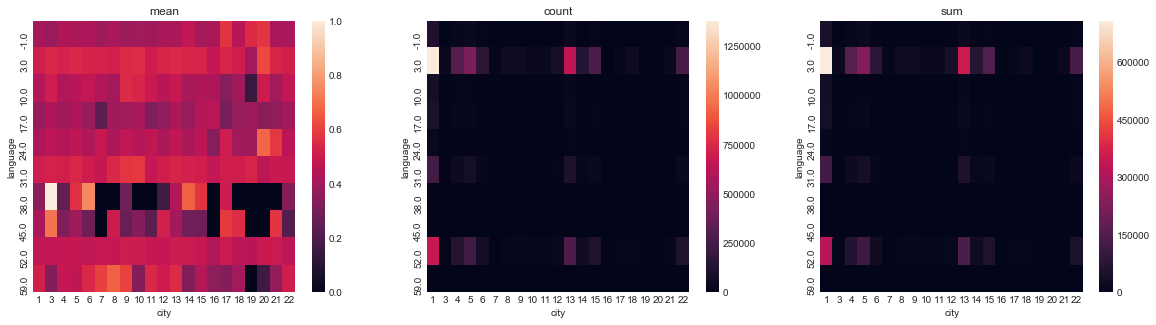

In [13]:
utils_nb.heatmap(data, 'language', 'city', annot=False)

## Age and Genres

In [ ]:
%%time
multi_catg_heatmap('genre_list', 'age')

## Popular Artist
-  We evaluate the popularity of the artist by calculate `mean * sum` by target label, value of target belong to [0, 1], so `sum` can represent the popularity but, maybe there are many 0 in the votes, so multiple the `mean` to get more fair result
-  According the boxplot, the popularity distribution is very skew, most of them close to zero, this is expected result, for this situation, we will add some features like the interaction between `[target + artist], [target + language]`..., etc.

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

<br/>
<br/>
<br/>
## Filter some rows

1. First we filter out the majority and the minority => [100 <= msno.group.size <= 1000], we don't want some majority to dominate the model
2. Insure that records of target = 1 greater than 35, we want 30% in valid data records of target = 1 greater than 10
    ```
    35 * 0.3 = 10.5
    ```

In [ ]:
""" Use DataFrameGroupBy.filter will be greate !!!"""
# msno_grp = data.groupby('msno')
# msno_grp.size().describe()

# df = pd.DataFrame({'size': msno_grp.size(), 'sum': msno_grp.target.sum()})

# data = data[data.msno.isin(df.query('sum >= 35 and 100 <= size and size <= 1000').index)]
# print(data.shape)
# print(data.target.value_counts())

In [ ]:
enc = utils.CounterEncoder()
enc.partial_fit( train.source_system_tab )

In [ ]:
np.linalg.norm([1, 2, 3] / np.linalg.norm([1, 2, 3]))


In [ ]:
feat = 'source_system_tab'
feat_dummies = pd.get_dummies(data[feat])
feat_dummies.columns = ['msno_%s_'%feat + '%s'%col for col in feat_dummies.columns]
feat_dummies.head()
feat_dummies['msno'] = data['msno'].values
feat_dummies = feat_dummies.groupby('msno').mean()
feat_dummies['msno'] = feat_dummies.index
a = members.merge(feat_dummies, on='msno', how='left')
a.head()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Appendix

+ Use `tf.saved_model.loader.load`, only for `json_serving_input_fn `

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = ctrl.local_predict_alt(params)
print(pred)

## Tensor data inspection

In [ ]:
%%time

encoded, origin, feat_data, target_, all_ = Ctrl.instance.inspect('promo2')

## Test

In [178]:
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

tf.reset_default_graph()
with tf.Graph().as_default():
    norm = tf.sequence_mask([1, 2, 3], dtype=tf.float32)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        print( sess.run(norm) )

[[1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]
